# Soft Ellipse RBF for Non-Convex Shape Classification

**A Neural Network Approach Using Soft Elliptical Radial Basis Functions**

---

## Table of Contents
1. [Abstract](#1-abstract)
2. [Environment Setup & Configuration](#2-environment-setup--configuration)
3. [Core Implementation](#3-core-implementation)
   - 3.1 [Utilities](#31-utilities--random-seed-management)
   - 3.2 [Data Generation Functions](#32-data-generation-functions)
   - 3.3 [Soft Ellipse RBF Layer](#33-soft-ellipse-rbf-layer)
   - 3.4 [Incremental Model Architecture](#34-incremental-model-architecture)
4. [Training Strategy](#4-training-strategy)
   - 4.1 [Pruning and Clustering](#41-pruning-and-dbscan-based-clustering)
   - 4.2 [Base Stage: Initial Unit Placement](#42-base-stage-initial-unit-placement)
   - 4.3 [ECR Stage: Error Cluster Refinement](#43-ecr-stage-error-cluster-refinement)
5. [Training Pipeline & Visualization](#5-training-pipeline--visualization)
6. [Experimental Results](#6-experimental-results)
7. [Interactive Drawing Canvas](#7-interactive-drawing-canvas)

---

## 1. Abstract

This notebook demonstrates a **soft ellipse radial basis function (RBF)** network that performs non‑convex shape classification.  We incrementally build the RBF model by adding elliptical units to cover the positive region, refine on error clusters using DBSCAN, and prune away insignificant units. 
The training pipeline proceeds in three stages:
1. **Base Stage**: Use DBSCAN on false negatives to guide the placement of initial units.
2. **Error Cluster Refinement (ECR) Stage**: Add extra units on false positives/negatives using density‑based clustering.
3. **Final Stage**: Fine‑tune the model with all units active.

Additionally, we visualize the evolving decision boundary after each epoch (*plot_frame_interval=5*) and log unit operations in detail (*verbose=1*).

### Key Implementation Features:

**🔧 Layer Parameters:**
- **Centers**: 2D coordinates (x, y) defining ellipse center positions
- **Semi-axes**: (a, b) controlling ellipse width and height  
- **Rotation angle**: ∠°(a-axis vs. Ox) for ellipse orientation  
- **Sigmoid sharpness**: K=10 for soft boundary transitions

**📊 Training Process:**
1. **Base Stage**: Incrementally adds RBF units targeting false negative clusters using DBSCAN
2. **ECR (Error Cluster Refinement)**: Refines model by addressing both false positives and false negatives
3. **Final Stage**: Fine-tuning with optimized hyperparameters

**🎯 Key Algorithms:**
- **DBSCAN clustering** for identifying error regions requiring new RBF units
- **Fast medoid selection** for optimal RBF center placement
- **Volume-based pruning** removes insignificant units (threshold: 1e-3)

The method achieves high IoU scores (>95%) on complex non-convex shapes including stars, donuts, and custom polygons while maintaining interpretable elliptical decision boundaries.

---

## 2. Environment Setup & Configuration

Setting up the environment with optimized TensorFlow configuration and importing required libraries for the soft ellipse RBF implementation.

In [1]:
# Suppress TensorFlow warnings and info messages - MUST BE FIRST!
import os
import warnings

# Set environment variables BEFORE importing TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress all TensorFlow logging
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'  # Disable oneDNN optimizations messages
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Disable CUDA messages (force CPU)

# Additional warning suppression
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

from typing import Callable, Optional
from time import sleep
import random, numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer, Dense

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, update_display, clear_output
from ipywidgets import Output, VBox

tf.get_logger().setLevel('ERROR')  # Only show TensorFlow errors

### Training Hyperparameters & Configuration

Comprehensive parameter settings for the three-stage training process, optimized for non-convex shape learning.

In [2]:
# TRAINING CONSTANTS
TEST_SIZE = 0.3
K_SIGMOID = 10  # Sigmoid sharpness for soft ellipse boundaries
PRUNE_BUMP_VOLUME_THRESHOLD = 1e-3  # Threshold for pruning small RBF units

# Base Stage - Initial RBF unit placement
BASE_MAX_UNITS = 7      # Maximum number of RBF units for Base Stage
BASE_BATCH = 16         # Batch size for base stage
BASE_EPOCHS = 50        # Number of base stage epochs 
BASE_ADAM = 3e-4        # Learning rate for Adam optimizer 
BASE_IOU_TARGET = 0.90  # IoU target for early stopping
BASE_PATIENCE = 15      # Patience for early stopping
BASE_MIN_DELTA = 2e-5   # Minimum delta for early stopping

# ECR Stage - Error Cluster Refinement by Biting & Patching
ECR_MAX_UNITS = 5       # How many extra units for ECR
ECR_BATCH = 24          # Batch size for ECR stage
ECR_EPOCHS = 50         # Number of ECR epochs
ECR_ADAM = 5e-4         # Learning rate for Adam optimizer
ECR_IOU_TARGET = 0.95   # ECR IoU target
ECR_PATIENCE = 20       # Patience ECR early stopping
ECR_MIN_DELTA = 2e-6    # Minimum delta ECR early stopping

# Final Stage - Fine-tuning
FINAL_BATCH = 32
FINAL_EPOCHS = 75
FINAL_ADAM = 5e-4

---

## 3. Core Implementation

### 3.1 Utilities

Essential utility functions 

In [3]:
def no_op(*args, **kwargs):
    """A do-nothing placeholder function for optional callbacks/logging."""
    pass

class RndSeed:
    """Centralized random seed management for reproducible experiments."""
    _seed: Optional[int] = None
    
    @classmethod
    def set_seed(cls, seed: int) -> None:
        """Set random seed across all ecosystems for reproducibility."""
        cls._seed = seed

        # Apply across ecosystems
        os.environ['PYTHONHASHSEED'] = str(seed)  # affects hashing-based ops
        random.seed(seed)                         # Python built-in RNG
        np.random.seed(seed)                      # NumPy RNG
        tf.keras.utils.set_random_seed(seed)      # TF + NumPy + Python        

        print(f"🎲 Random seed set to: {seed}")

    @classmethod
    def get_seed(cls) -> int:
        """Get current seed, initializing if needed."""
        if cls._seed is None:
            # lazy init with silent auto-seed
            cls.set_seed(np.random.randint(0, 2**31 - 1))
        return cls._seed # type: ignore

def fast_medoid(points, n_sample=500):
    """Compute approximate medoid of points using sampling for efficiency.
    
    Args:
        points: Array of 2D points
        n_sample: Maximum points to sample for medoid computation
        
    Returns:
        Medoid point coordinates
    """
    N = len(points)
    if N == 0:
        return None
    if N > n_sample:
        idx_sample = np.random.choice(N, n_sample, replace=False)
        sample = points[idx_sample]
    else:
        sample = points
    
    dists = np.linalg.norm(sample[:, None, :] - sample[None, :, :], axis=2)
    medoid_idx = np.argmin(dists.sum(axis=1))
    medoid_point = sample[medoid_idx]
    return medoid_point

def compute_iou(model, X, y):
    """Compute Intersection over Union (IoU) metric for binary classification."""
    preds = (model.predict(X, verbose=0).reshape(-1) > 0.5).astype(int)
    inter = np.sum((preds==1) & (y==1))
    union = np.sum((preds==1) | (y==1))
    return inter/union if union>0 else 0.0

def plot_decision_boundary(model, X_data, y_data, ax, grid_resolution=100, title="Decision Boundary"):
    """Unified function to plot decision boundary with data points.
    
    Args:
        model: Trained model with predict method
        X_data: Data points to scatter plot
        y_data: True labels for the data points
        ax: Matplotlib axis to plot on (required)
        grid_resolution: Resolution of the decision boundary grid
        title: Title for the plot
    """
    # Create grid for decision boundary
    xx, yy = np.meshgrid(
        np.linspace(0, 1, grid_resolution),
        np.linspace(0, 1, grid_resolution)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Get model predictions on grid
    probs = model.predict(grid, verbose=0).reshape(xx.shape)
    
    # Plot on provided axis
    ax.contourf(xx, yy, probs, levels=50, cmap="RdBu", alpha=0.6)
    ax.contour(xx, yy, probs, levels=[0.5], colors="black", linewidths=2)
    ax.scatter(X_data[:,0], X_data[:,1], c=y_data, cmap="bwr", edgecolor="k", s=12, alpha=0.6)
    ax.set_title(title)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

### 3.2 Data Generation Functions

Collection of synthetic data generators for testing the RBF network on various non-convex shapes.

In [4]:
def generate_polygon_data(n=2000, corners=None):
    """Generate binary classification data for arbitrary polygon shapes.
    
    Args:
        n: Number of data points to generate
        corners: List of (x, y) tuples defining polygon vertices
        
    Returns:
        X: Data points (n, 2)
        y: Binary labels (inside=1, outside=0)
        corners: Polygon corner coordinates
    """
    if corners is None:
        corners = [(0.5, 0.8), (0.1, 0.1), (0.9, 0)]

    X = np.random.uniform(0, 1, size=(n, 2))

    def point_in_polygon(point, polygon_corners):
        """Ray casting algorithm for point-in-polygon test."""
        x, y = point
        n = len(polygon_corners)
        inside = False
        p1x, p1y = polygon_corners[0]
        for i in range(1, n + 1):
            p2x, p2y = polygon_corners[i % n]
            if y > min(p1y, p2y):
                if y <= max(p1y, p2y):
                    if x <= max(p1x, p2x):
                        if p1y != p2y:
                            xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                        if p1x == p2x or x <= xinters:
                            inside = not inside
            p1x, p1y = p2x, p2y
        return inside

    y = np.array([point_in_polygon(pt, corners) for pt in X]).astype(np.int32)
    return X, y, corners

def generate_donut_data(n=2000, inner_radius=0.25, outer_radius=0.4):
    """Generate donut/annulus shape data."""
    X = np.random.uniform(0, 1, (n, 2))
    cx, cy = np.random.uniform(0.45, 0.55, 2)
    dist = np.sqrt((X[:,0]-cx)**2 + (X[:,1]-cy)**2)
    y = ((dist < outer_radius) & (dist > inner_radius)).astype(np.float32)
    return X, y, (cx, cy, inner_radius, outer_radius)

def generate_eight_shape_data(n=2000, inner_radius_1=0.15, outer_radius_1=0.25, inner_radius_2=0.2, outer_radius_2=0.3):
    """Generate figure-eight or double donut shape data."""
    X = np.random.uniform(0, 1, (n, 2))
    cx_1, cy_1 = np.random.uniform(0.3, 0.35, 2)
    cx_2, cy_2 = np.random.uniform(0.6, 0.65, 2)
    dist_1 = np.sqrt((X[:,0]-cx_1)**2 + (X[:,1]-cy_1)**2)
    dist_2 = np.sqrt((X[:,0]-cx_2)**2 + (X[:,1]-cy_2)**2)
    y = (((dist_1 < outer_radius_1) & (dist_1 > inner_radius_1)) | ((dist_2 < outer_radius_2) & (dist_2 > inner_radius_2))).astype(np.float32)
    return X, y, (cx_1, cy_1, inner_radius_1, outer_radius_1, cx_2, cy_2, inner_radius_2, outer_radius_2)

def generate_n_star_data(n=2000, n_corners=5, inner_radius=0.25, outer_radius=0.4):
    """Create n-pointed star shape data by defining outer and inner corners.
    
    Args:
        n: Number of data points
        n_corners: Number of star points
        inner_radius: Radius of inner vertices
        outer_radius: Radius of outer vertices (star tips)
    """
    angles = np.linspace(0, 2 * np.pi, n_corners, endpoint=False)
    # Adding some noise to make it less regular
    angles += np.random.uniform(-0.1, 0.1, size=n_corners)
    outer_corners = np.c_[np.cos(angles), np.sin(angles)] * outer_radius
    inner_corners = np.c_[np.cos(angles + np.pi / n_corners), np.sin(angles + np.pi / n_corners)] * inner_radius
    corners = []
    for i in range(n_corners):
        corners.append((outer_corners[i,0]+0.5, outer_corners[i,1]+0.5))
        corners.append((inner_corners[i,0]+0.5, inner_corners[i,1]+0.5))
    return generate_polygon_data(n, corners)

### 3.3 Soft Ellipse RBF Layer

The core neural network layer implementing soft elliptical radial basis functions with dynamic unit management.

In [5]:
class SoftEllipseRBFLayer(Layer):
    """Custom Keras layer implementing Soft Elliptical Radial Basis Functions.
    
    This layer can dynamically add RBF units during training, starting from 0 units
    and incrementally growing based on training needs.
    
    Each RBF unit is defined by:
    - Center: (x, y) position
    - Semi-axes: (a, b) controlling ellipse dimensions
    - Angle: θ controlling ellipse rotation
    
    The activation function is: φ(x) = sigmoid(K * (1 - ||R*(x-c)||/axes))
    where R is the rotation matrix and K controls softness.
    """
    
    def __init__(self, max_units=BASE_MAX_UNITS+ECR_MAX_UNITS, **kwargs):
        super().__init__(**kwargs)
        self.max_units = max_units
        self.num_units = tf.Variable(tf.constant(0, dtype=tf.int32), trainable=False, name="num_units")

    def build(self, input_shape):
        # Pre-allocate maximum space for all parameters
        self.centers = self.add_weight(name="centers",
            shape=(self.max_units, 2),
            initializer="zeros",
            constraint=tf.keras.constraints.MinMaxNorm(min_value=-2.0, max_value=2.0),
            trainable=True)

        self.axes = self.add_weight(name="axes",
            shape=(self.max_units, 2),
            initializer=keras.initializers.Constant(0.1),
            regularizer=keras.regularizers.l2(1e-5),
            constraint=tf.keras.constraints.MinMaxNorm(min_value=0.02, max_value=2.0),
            trainable=True)

        self.angles = self.add_weight(name="angles",
            shape=(self.max_units,),
            initializer="zeros",
            trainable=True)

    def add_unit(self, center, axes, angle, log=no_op):
        """Add a new RBF unit by updating the next available slot.
        
        Args:
            center: (x, y) center coordinates
            axes: (a, b) semi-axis lengths
            angle: rotation angle in radians
            log: optional logging function
        """
        if log:
            log(f"add unit: center={center}, axes(a,b)={axes}, angle(a)={np.degrees(angle):.1f}°")
        current_units = int(self.num_units.numpy())
        if current_units >= self.max_units:
            raise ValueError(f"Cannot add more units. Maximum is {self.max_units}")
        
        # Update the parameters at the current index
        self.centers[current_units:current_units+1].assign(center[None])
        self.axes[current_units:current_units+1].assign(axes[None])
        self.angles[current_units:current_units+1].assign([angle])
        
        # Increment the unit counter
        self.num_units.assign_add(1)

    def call(self, inputs):
        """Forward pass computing RBF activations for all active units."""
        n = self.num_units

        def no_units():
            batch_size = tf.shape(inputs)[0]
            return tf.zeros((batch_size, 0), dtype=tf.float32)

        def some_units():
            centers = self.centers[:n]
            axes    = self.axes[:n]
            angles  = self.angles[:n]

            # Compute distance from input to each center
            diff = tf.expand_dims(tf.cast(inputs, tf.float32), 1) - centers
            
            # Apply rotation transformation
            c, s = tf.cos(angles), tf.sin(angles)
            R = tf.stack([
                tf.stack([c, -s], axis=-1),
                tf.stack([s,  c], axis=-1)
            ], axis=-2)

            diff_rot = tf.einsum('bij,ijk->bik', diff, R)
            
            # Add numerical stability: ensure axes are not too small and add epsilon
            stable_axes = tf.maximum(axes, 1e-4)
            eps = 1e-8
            stable_diff_rot = diff_rot + tf.sign(diff_rot) * eps
            
            # Compute normalized distance (elliptical)
            norm = stable_diff_rot / stable_axes
            tf.debugging.check_numerics(norm, "norm contains NaN or Inf!")
            d = tf.norm(norm, axis=-1)
            tf.debugging.check_numerics(d, "d contains NaN or Inf!")
            
            # Clamp d to prevent extreme values
            d = tf.clip_by_value(d, 1e-8, 1e4)
            
            # Apply soft sigmoid activation
            phi = tf.sigmoid(K_SIGMOID * (1.0 - d))
            tf.debugging.check_numerics(phi, "phi contains NaN or Inf!")
            return phi

        return tf.cond(tf.equal(n, 0), no_units, some_units)

### 3.4 Incremental Model Architecture

Complete model architecture that combines the Soft Ellipse RBF layer with a dense output layer, supporting incremental unit addition during training.

In [6]:
class IncrementalModel(tf.keras.Model):
    """Neural network model with incremental RBF unit addition capability.
    
    The model consists of:
    1. SoftEllipseRBFLayer: Produces RBF activations
    2. Dense layer: Linear combination of RBF outputs → sigmoid → probability
    
    Key features:
    - Starts with 0 RBF units
    - Units can be added dynamically during training
    - Dense layer weights are initialized to handle variable RBF units
    """
    
    def __init__(self, input_dim=2, max_units=BASE_MAX_UNITS+ECR_MAX_UNITS):
        assert 0 < max_units <= BASE_MAX_UNITS+ECR_MAX_UNITS
        super().__init__()
        self.max_units = max_units
        self.rbf = SoftEllipseRBFLayer(max_units=max_units)
        self.dense = Dense(1, activation="sigmoid")
        
        # Build the dense layer to initialize weights
        self.dense.build((None, max_units))
        
        # Initialize dense layer for 0 active units
        initial_weights = np.zeros((max_units, 1))
        initial_bias = np.array([-2.0])  # Bias towards negative prediction initially
        self.dense.set_weights([initial_weights, initial_bias])
        
    def call(self, inputs):
        """Forward pass with dynamic padding for variable RBF units."""
        rbf_output = self.rbf(inputs)
        n_active = self.rbf.num_units

        def pad_and_dense():
            # Pad RBF output to match dense layer input size
            batch_size = tf.shape(rbf_output)[0]
            padding_size = self.max_units - n_active
            padding = tf.zeros((batch_size, padding_size))
            padded_rbf_output = tf.concat([rbf_output, padding], axis=1)
            return self.dense(padded_rbf_output)
        
        def zero_dense():
            # Handle case with no active RBF units
            batch_size = tf.shape(inputs)[0]
            padded_rbf_output = tf.zeros((batch_size, self.max_units))
            return self.dense(padded_rbf_output)
        
        return tf.cond(tf.equal(n_active, 0), zero_dense, pad_and_dense)

    def add_unit(self, center, axes, angle, init_weight=0.1, log=no_op):
        """Add new RBF unit and initialize its corresponding dense layer weight.
        
        Args:
            center: RBF center coordinates
            axes: RBF semi-axis lengths
            angle: RBF rotation angle
            init_weight: Initial weight for the new unit in dense layer
            log: Optional logging function
        """
        # Add unit to RBF layer
        self.rbf.add_unit(center, axes, angle, log=log)
        
        # Set the weight for the new unit in the dense layer
        current_units = int(self.rbf.num_units.numpy()) - 1 
        self.dense.kernel[current_units:current_units+1].assign([[init_weight]])


---

## 4. Training Strategy

### 4.1 Pruning and DBSCAN-based Clustering

After each unit is added and the resulting model re-trained, some units may have minimal impact.  
We prune those whose **ellipse area × absolute weight** falls below a threshold, ensuring only significant units remain.  

Strategic placement of new RBF units is guided by clustering analysis using density‑based clustering via DBSCAN to find the largest false positive/negative clusters.


In [7]:
def prune_small_units(model, threshold=PRUNE_BUMP_VOLUME_THRESHOLD, log=None):
    """Prune RBF units whose area × |weight| < threshold.
    
    The importance of an RBF unit is measured by the product of:
    - Its elliptical area: π × a × b
    - The absolute value of its output weight
    
    Units with low importance are removed to prevent overfitting and
    improve model interpretability.
    
    Args:
        model: IncrementalModel instance
        threshold: Minimum importance threshold
        log: Optional logging function
        
    Returns:
        Number of units removed
    """
    rbf_layer = model.rbf
    dense_layer = model.dense
    
    n_active = int(rbf_layer.num_units.numpy())
    if n_active == 0:
        return 0
    
    # Extract parameters for active units only
    active_centers = rbf_layer.centers[:n_active].numpy()
    active_axes = rbf_layer.axes[:n_active].numpy()
    active_angles = rbf_layer.angles[:n_active].numpy()
    active_weights = dense_layer.kernel[:n_active].numpy().flatten()

    # Compute elliptical area for each unit
    areas = np.pi * active_axes[:, 0] * active_axes[:, 1]

    # Calculate importance as area × |weight|
    importance = areas * np.abs(active_weights)

    # Determine which units to keep
    keep_indices = importance >= threshold
    n_keep = np.sum(keep_indices)
    
    if n_keep > 0 and n_keep < n_active:
        if log:
            log(f"Pruning {n_active - n_keep} small units out of {n_active}.")

        # Keep only the selected active units
        kept_centers = active_centers[keep_indices]
        kept_axes = active_axes[keep_indices]
        kept_angles = active_angles[keep_indices]
        kept_weights = active_weights[keep_indices]
        
        # Reset all parameters to default values
        rbf_layer.centers.assign(tf.zeros_like(rbf_layer.centers))
        rbf_layer.axes.assign(tf.constant(0.1, shape=rbf_layer.axes.shape))
        rbf_layer.angles.assign(tf.zeros_like(rbf_layer.angles))
        dense_layer.kernel.assign(tf.zeros_like(dense_layer.kernel))
        
        # Assign the kept units to the beginning of parameter arrays
        rbf_layer.centers[:n_keep].assign(kept_centers)
        rbf_layer.axes[:n_keep].assign(kept_axes)
        rbf_layer.angles[:n_keep].assign(kept_angles)
        dense_layer.kernel[:n_keep].assign(kept_weights.reshape(-1, 1))
        
        # Update the number of active units
        rbf_layer.num_units.assign(n_keep)
    elif n_keep == 0:
        if log:
            log(f"All {n_active} units would be pruned! Keeping all units.")
        return 0
    
    return n_active - n_keep

def guess_dbscan_params(n_false, n_true, n_sample,
                        min_min_samples=4, max_min_samples=20,
                        eps_min=1e-2, eps_max=1.0):
    """Estimate optimal DBSCAN parameters based on data characteristics.
    
    Args:
        n_false: Number of false prediction points
        n_true: Number of true prediction points 
        n_sample: Total sample size
        
    Returns:
        eps: Neighborhood radius for DBSCAN
        min_samples: Minimum points required to form a cluster
    """
    if n_false <= 0:
        return 0.0, 0

    # Rule-of-thumb: min_samples scales with sqrt of false points
    min_samples = int(np.clip(round(np.sqrt(n_false)), min_min_samples, max_min_samples))
    
    # Effective area occupied by false points
    A_eff = (n_false + n_true) / n_sample
    A_eff = np.clip(A_eff, 0.01, 0.5)

    # Estimate eps based on expected cluster density
    beta = 1.2  # Scale factor for cluster connectivity
    eps = np.sqrt(min_samples * A_eff / (np.pi * n_false)) * beta
    eps = np.clip(eps, eps_min, eps_max)

    return eps, min_samples

def get_max_cluster(false_points, fn_fp="", eps=0.1, min_samples=10, log=no_op):
    """Use DBSCAN to find the largest cluster in false prediction points.
    
    Args:
        false_points: Points where model predictions are incorrect
        fn_fp: Label for logging ("FN" or "FP")
        eps: DBSCAN neighborhood radius
        min_samples: Minimum cluster size
        log: Logging function
        
    Returns:
        cluster_size: Size of the largest cluster
        cluster_points: Points belonging to the largest cluster
    """
    labels_false = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(false_points)

    size_noise = (labels_false == -1).sum()
    # Drop noise points (labeled as -1)
    mask = labels_false != -1
    filtered_false_points = false_points[mask]
    filtered_false_labels = labels_false[mask]

    cluster_points = []
    cluster_size = 0

    unique_clusters = set(filtered_false_labels)
    if len(unique_clusters) >= 1:
        if log:
            log(len(unique_clusters), f"false {fn_fp} clusters found (noises dropped: {size_noise})")
            for cluster_id in unique_clusters:
                log("False Cluster ID:", cluster_id,
                      "size:", np.sum(filtered_false_labels == cluster_id))

        # Select the largest cluster
        most_important_cluster = max(
            unique_clusters,
            key=lambda x: np.sum(filtered_false_labels == x)
        )
        cluster_points = filtered_false_points[filtered_false_labels == most_important_cluster]
        cluster_size = len(cluster_points)

    return cluster_size, cluster_points

### 4.2 Base Stage: Initial Unit Placement

The base stage incrementally adds RBF units by identifying clusters of false negative predictions and placing units at their medoids.

In [8]:
def base_stage_incremental_training(model, X_train, y_train, X_val, y_val, cb, log=no_op):
    """Base stage: Incrementally add RBF units targeting false negative clusters.
    
    Strategy:
    1. Identify false negative predictions
    2. Cluster false negatives using DBSCAN
    3. Place new RBF unit at largest cluster's medoid
    4. Train model and repeat until IoU target is reached
    
    Args:
        model: IncrementalModel instance
        X_train, y_train: Training data
        X_val, y_val: Validation data (can be None)
        cb: List of Keras callbacks
        log: Logging function
        
    Returns:
        model: Trained model
        iou: Final IoU score
    """
    n_samples = X_train.shape[0]
    iou = 0.0
    n_in, n_out = np.bincount(y_train.astype(int))
    n_real_hits = 0 

    while int(model.rbf.num_units.numpy()) < BASE_MAX_UNITS:
        n_real_hits += 1
        if n_real_hits > BASE_MAX_UNITS * 2:
            log("Too many iterations without improvement, stopping.")
            break

        # Identify false negatives (model predicts 0, true label is 1)
        y_pred = (model.predict(X_train, verbose=0).reshape(-1) > 0.5).astype(int)
        false_neg = X_train[(y_pred==0) & (y_train==1)]
        if len(false_neg) == 0:
            log("No false negatives left, stopping unit addition.")
            break

        n_false_neg = len(false_neg)
        n_true_neg = n_out - n_false_neg
        log(f"False negative count: {n_false_neg} | True negative count: {n_true_neg}")
        
        # Estimate DBSCAN parameters and find largest cluster
        eps_FN, min_FN = guess_dbscan_params(n_false_neg, n_true_neg, n_samples)
        log(f"DBSCAN params for FN: eps={eps_FN:.4f}, min_samples={min_FN}")
        size_FN, points_FN = get_max_cluster(false_neg, fn_fp="FN", eps=eps_FN, min_samples=min_FN, log=log)
        log(f"False negative size: {size_FN}")

        # Check if we have a valid cluster before proceeding
        if size_FN == 0:
            log("No false negative cluster found, skipping unit addition.")
            continue

        # Place new RBF unit at cluster medoid
        centroid = fast_medoid(points_FN)
        log(f"Chosen centroid for new unit: {centroid}")
        
        # Initialize with small, roughly circular ellipse
        a = np.random.uniform(0.1, 0.15)
        b = np.random.uniform(0.1, 0.15)
        model.add_unit(centroid, np.array([a,b]), np.random.uniform(0, np.pi), init_weight=2, log=log)
          
        # Train model with new unit
        model.fit(X_train, y_train, 
                  batch_size=BASE_BATCH,
                  epochs=BASE_EPOCHS, 
                  validation_data=(X_val, y_val) if X_val is not None else None, 
                  callbacks=cb, 
                  verbose=0
                  )
                  
        # Log current model state
        n_active = int(model.rbf.num_units.numpy())
        log("centers:", model.rbf.centers[:n_active].numpy())
        log("axes:", model.rbf.axes[:n_active].numpy())
        log("weights:", model.dense.kernel[:n_active].numpy().T)

        # Check if IoU target reached
        if X_val is not None:
            iou = compute_iou(model, X_val, y_val)
        else:
            iou = compute_iou(model, X_train, y_train)

        if iou >= BASE_IOU_TARGET:
            log(f"Base Stage reached IoU target of {BASE_IOU_TARGET*100:.1f}%, stopping stage early.")
            break
        
        # Remove insignificant units
        prune_small_units(model, log=log)

    # Final base stage training
    model.fit(X_train, y_train, 
                batch_size=ECR_BATCH,
                epochs=BASE_EPOCHS, 
                validation_data=(X_val, y_val) if X_val is not None else None, 
                callbacks=cb, 
                verbose=0
                )
    
    # Final IoU computation
    if X_val is not None:
        iou = compute_iou(model, X_val, y_val)
    else:
        iou = compute_iou(model, X_train, y_train)

    return model, iou

### 4.3 ECR Stage: Error Cluster Refinement

The ECR (Error Cluster Refinement) stage addresses remaining prediction errors by analyzing both false positives and false negatives.

In [9]:
def ecr_stage_incremental_training(model, X_train, y_train, X_val, y_val, cb, log=no_op):
    """ECR stage: Refine model by addressing both false positives and negatives.
    
    Strategy:
    1. Analyze both false positive and false negative clusters
    2. Select most significant error cluster
    3. Add RBF unit with appropriate weight sign:
       - Negative weight for false positive regions
       - Positive weight for false negative regions
    4. Size RBF unit based on cluster spread
    
    Args:
        model: IncrementalModel from base stage
        X_train, y_train: Training data
        X_val, y_val: Validation data (can be None)
        cb: List of Keras callbacks
        log: Logging function
        
    Returns:
        model: Refined model
        iou: Final IoU score
    """
    n_samples = X_train.shape[0]
    iou = 0.0
    n_in, n_out = np.bincount(y_train.astype(int))
    n_real_hits = 0

    while int(model.rbf.num_units.numpy()) < BASE_MAX_UNITS + ECR_MAX_UNITS:
        n_real_hits += 1
        if n_real_hits > ECR_MAX_UNITS * 2:
            log("Too many extra iterations without improvement, stopping.")
            break

        y_pred = (model.predict(X_train, verbose=0).reshape(-1) > 0.5).astype(int)

        # Analyze false positive clusters (model predicts 1, true label is 0)
        false_pos = X_train[(y_pred==1) & (y_train==0)]
        n_false_pos = len(false_pos)
        n_true_pos = n_in - n_false_pos
        log("False positive count:", n_false_pos, "| True positive count:", n_true_pos)
        eps_FP, min_FP = guess_dbscan_params(n_false_pos, n_true_pos, n_samples)
        size_FP, points_FP = get_max_cluster(false_pos, fn_fp="FP", eps=eps_FP, min_samples=min_FP, log=log)

        # Analyze false negative clusters
        false_neg = X_train[(y_pred==0) & (y_train==1)]
        n_false_neg = len(false_neg)
        n_true_neg = n_out - n_false_neg
        log("False negative count:", n_false_neg, "| True negative count:", n_true_neg)
        eps_FN, min_FN = guess_dbscan_params(n_false_neg, n_true_neg, n_samples)
        size_FN, points_FN = get_max_cluster(false_neg, fn_fp="FN", eps=eps_FN, min_samples=min_FN, log=log)

        if size_FP == 0 and size_FN == 0:
            log("No more clusters found. Stopping extra fine-tuning.")
            break

        # Select most significant cluster based on relative error rates
        if size_FP/n_out >= size_FN/n_in and size_FP > 0:
            log(f"Most important cluster is FP with size {size_FP} (eps={eps_FP:.3f}, min_samples={min_FP})")
            init_weight = -1  # Negative weight to suppress false positives
            cluster_points = points_FP
            cluster_size = size_FP
        else:
            log(f"Most important cluster is FN with size {size_FN} (eps={eps_FN:.3f}, min_samples={min_FN})")   
            init_weight = +1  # Positive weight to enhance false negatives
            cluster_points = points_FN
            cluster_size = size_FN

        # Safety check: ensure we have a valid cluster
        if cluster_size == 0 or len(cluster_points) == 0:
            if log:
                log("Selected cluster is empty, skipping unit addition.")
            continue

        # Scale weight and add noise for robustness
        beta_factor = 2.0
        init_weight = init_weight * np.random.uniform(0.95, 1.05) * beta_factor
        centroid = fast_medoid(cluster_points) * np.random.uniform(0.98, 1.02)

        # Size RBF unit based on cluster spread
        cluster_min = cluster_points.min(axis=0)
        cluster_max = cluster_points.max(axis=0)

        gamma_factor = 0.2  # Fraction of cluster span for RBF size
        a = gamma_factor * (cluster_max[0] - cluster_min[0]) * np.random.uniform(0.98, 1.02)
        b = gamma_factor * (cluster_max[1] - cluster_min[1]) * np.random.uniform(0.98, 1.02)

        log(f"adding unit for false cluster: center({centroid[0]:.2f}, {centroid[1]:.2f}) (a={a:.2f}, b={b:.2f}) - n_size = {len(cluster_points)} weight={init_weight:.2f}")
        model.add_unit(centroid, np.array([a,b]), 0, init_weight=init_weight, log=log)

        # Train model with new unit
        model.fit(X_train, y_train, 
                  batch_size=ECR_BATCH,
                  epochs=ECR_EPOCHS, 
                  validation_data=(X_val, y_val) if X_val is not None else None, 
                  callbacks=cb, 
                  verbose=0
                  )

        # Check if ECR IoU target reached
        if X_val is not None:
            iou = compute_iou(model, X_val, y_val)
        else:
            iou = compute_iou(model, X_train, y_train)

        if iou >= ECR_IOU_TARGET:
            log(f"ECR Stage reached IoU target of {ECR_IOU_TARGET*100:.1f}%, stopping stage early.")
            break

        # Remove insignificant units
        prune_small_units(model, log=log)

    # Final ECR stage training
    model.fit(X_train, y_train, 
                batch_size=FINAL_BATCH,
                epochs=ECR_EPOCHS, 
                validation_data=(X_val, y_val) if X_val is not None else None, 
                callbacks=cb, 
                verbose=0
                )

    # Final IoU computation
    if X_val is not None:
        iou = compute_iou(model, X_val, y_val)
    else:
        iou = compute_iou(model, X_train, y_train)
        
    return model, iou


---

## 5. Training Pipeline & Visualization

Comprehensive training pipeline with real-time visualization of the learning process, including training progress, RBF unit evolution, and decision boundary formation.

In [10]:
class PlotCallback(tf.keras.callbacks.Callback):
    """Custom Keras callback for real-time training visualization.
    
    Displays:
    - Training data with current RBF ellipses
    - Decision boundary evolution
    - Training metrics and progress
    """
    
    def __init__(self, X_train, y_train, ax1, ax2, out_plots, stage_info="", interval=2, log=no_op):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.ax1 = ax1  # For training progress
        self.ax2 = ax2  # For decision boundary
        self.out_plots = out_plots
        self.stage_info = stage_info
        self.interval = interval
        self.log = log
        
    def on_epoch_end(self, epoch, logs=None):
        # Get total epochs from params
        total_epochs = self.params.get('epochs', -1)
        
        # Show every interval epochs OR the last epoch
        is_last_epoch = (epoch + 1) == total_epochs
        if epoch % self.interval != 0 and not is_last_epoch:
            return

        # Clear both axes
        self.ax1.clear()
        self.ax2.clear()
        
        n_active = int(self.model.rbf.num_units.numpy())

        # Plot training data on ax1 with ellipses
        self.ax1.scatter(self.X_train[:,0], self.X_train[:,1], c=self.y_train, cmap="bwr", edgecolor="k", s=14, alpha=0.6)

        # Plot RBF ellipses on ax1 with color coding by weight
        if n_active > 0:
            active_centers = self.model.rbf.centers[:n_active].numpy()
            active_axes = self.model.rbf.axes[:n_active].numpy()
            active_angles = self.model.rbf.angles[:n_active].numpy()
            active_weights = self.model.dense.kernel[:n_active].numpy().flatten()
            
            for center, axes, angle, w in zip(active_centers, active_axes, active_angles, active_weights):
                color = "orange" if w > 0 else "cyan"  # Orange for positive, cyan for negative weight
                e = patches.Ellipse(
                    xy=center,
                    width=2*axes[0],
                    height=2*axes[1],
                    angle=np.degrees(angle),
                    fill=False,
                    edgecolor=color,
                    lw=2.5
                )
                self.ax1.add_patch(e)

        # Plot decision boundary on ax2
        plot_decision_boundary(self.model, 
                               self.X_train, self.y_train, 
                               self.ax2, 
                               grid_resolution=100, 
                               title=f"Training Decision Boundary\n(seed={RndSeed.get_seed()})"
                               )

        # Get and display metrics
        train_acc = logs.get('binary_accuracy', 0) if logs else 0
        train_iou = compute_iou(self.model, self.X_train, self.y_train)

        # Set descriptive titles
        epoch_info = f"Epoch {epoch+1}/{total_epochs}" if total_epochs > 0 else f"Epoch {epoch+1}"
        self.ax1.set_title(f"{self.stage_info} | Units={n_active} | {epoch_info}\ntrain_acc={train_acc:.4f} | train_iou={train_iou*100:.1f}%")
        
        self.ax1.set_xlim(0, 1)
        self.ax1.set_ylim(0, 1)
        
        # Update display
        fig = self.ax1.figure
        if self.out_plots:
            with self.out_plots:
                clear_output(wait=True)
                display(fig)
        else:
            clear_output(wait=True)
            display(fig)

class VerboseEarlyStopping(tf.keras.callbacks.EarlyStopping):
    """Enhanced EarlyStopping with detailed logging."""
    
    def __init__(self, log=no_op, **kwargs):
        super().__init__(**kwargs)
        self.log = log

    def on_train_end(self, logs=None):
        super().on_train_end(logs)
        if self.stopped_epoch > 0 and self.log:
            self.log(f"\n🛑 Training stopped at epoch {self.stopped_epoch+1}.")
            self.log(f"Reason: No improvement in '{self.monitor}' for {self.patience} epochs "
                     f"(min_delta={self.min_delta}). Best val_binary_accuracy: {self.best:.4f}")

In [11]:
def build_and_train_model(X, y, b_validation=True, plot_frame_interval=3, verbose=0):
    """Complete training pipeline for Soft Ellipse RBF model.
    
    Executes the three-stage training process:
    1. Base Stage: Initial RBF placement targeting false negatives
    2. ECR Stage: Error cluster refinement for both FP and FN
    3. Final Stage: Fine-tuning with optimized parameters
    
    Args:
        X, y: Dataset for training
        b_validation: Whether to use train/validation split
        plot_frame_interval: Epochs between visualization updates
        verbose: Logging verbosity (0=silent, 1=full)
        
    Returns:
        model: Trained IncrementalModel
        iou: Final IoU score
        X_train, y_train: Training data
        X_val, y_val: Validation data (or None)
    """

    # Data splitting
    if b_validation:
        test_size = TEST_SIZE
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, stratify=y, random_state=RndSeed.get_seed())
    else:
        test_size = 0.0
        X_train, y_train = X, y
        X_val, y_val = None, None

    # Setup visualization
    plt.style.use('default')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    ax3.set_aspect('equal')
    ax3.set_visible(False)  # Hide third subplot initially

    # Initial data visualization
    ax1.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="bwr", edgecolor="k", s=14, alpha=0.6)
    ax1.set_title("Training Data")
    ax2.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="bwr", edgecolor="k", s=14, alpha=0.6)
    ax2.set_title("Training Decision Boundary")

    # Setup logging
    out_logs = None
    out_plots = None
    log = no_op
    
    if verbose == 1:
        out_plots = Output(layout={'border': '0px solid black'})
        out_logs = Output(layout={'border': '1px solid black'})
        outs = [out_logs, out_plots]
        
        def log_fn(*args, **kwargs):
            with out_logs:
                print(*args, **kwargs)
        log = log_fn
        
        log(f"🎲 Random seed set to: {RndSeed.get_seed()}\n")
        
        with out_plots:
            clear_output(wait=True)
            display(fig)

        display(VBox(outs, layout={'width': '100%'}))
    else:
        print(f"🎲 Random seed set to: {RndSeed.get_seed()}")
        clear_output(wait=True)
        display(fig)

    # Dataset statistics
    n_samples = X.shape[0]
    n_out = np.sum(y == 0)  # count of 0s (outside shape)
    n_in = np.sum(y == 1)   # count of 1s (inside shape)
    log(f"📊 Dataset: {n_samples} samples = {n_in}(1s) + {n_out}(0s) "
        f"| proportions: {n_in/n_samples:.2%}(1s) - {n_out/n_samples:.2%}(0s) "
        f"| training-validation split: {1-test_size:.2f} - {test_size:.2f}\n")

    # Setup callbacks
    plot_cb = PlotCallback(X_train, y_train, ax1, ax2, out_plots=out_plots, 
                          stage_info="Base Stage", interval=plot_frame_interval, log=log)
    es_cb = VerboseEarlyStopping(
                    monitor='val_binary_accuracy',
                    patience=BASE_PATIENCE,
                    min_delta=BASE_MIN_DELTA,
                    mode='max',
                    restore_best_weights=True,
                    log=log
                )
    cb = [plot_cb, es_cb]

    # 🔥 BASE STAGE
    log("-" * 50)
    log("🔥 Starting Base Stage...\n")
    model = IncrementalModel(input_dim=X_train.shape[1], max_units=BASE_MAX_UNITS+ECR_MAX_UNITS)
    model.compile(
            optimizer=tf.keras.optimizers.Adam(BASE_ADAM),
            loss="mse",
            # loss="binary_crossentropy",
            metrics=[tf.keras.metrics.BinaryAccuracy()]
            )    

    model, val_iou = base_stage_incremental_training(model, X_train, y_train, X_val, y_val, cb, log=log)
    log(f"\n✅ Base stage ended with: units={int(model.rbf.num_units.numpy())}, val_iou={val_iou*100:.2f}% \n")

    # 🔧 ECR STAGE
    log("-" * 50)
    log("🔧 Starting ECR Stage...\n")
    model.compile(
            optimizer=tf.keras.optimizers.Adam(ECR_ADAM),
            loss="mse",
            # loss="binary_crossentropy",
            metrics=[tf.keras.metrics.BinaryAccuracy()]
            )

    es_cb.patience = ECR_PATIENCE
    es_cb.min_delta = ECR_MIN_DELTA
    plot_cb.stage_info = "ECR Stage"
    model, val_iou = ecr_stage_incremental_training(model, X_train, y_train, X_val, y_val, cb, log=log)
    log(f"\n✅ ECR stage ended with: units={int(model.rbf.num_units.numpy())}, val_iou={val_iou*100:.2f}%")

    # 🎯 FINAL STAGE
    log("🎯 Starting Final Stage fine-tuning...")
    model.compile(optimizer=tf.keras.optimizers.Adam(FINAL_ADAM),
                loss="mse",
                # loss="binary_crossentropy",
                metrics=[tf.keras.metrics.BinaryAccuracy()]
                )
    
    plot_cb.stage_info = "Final Stage fine-tuning"
    model.fit(X_train, y_train, 
              batch_size=FINAL_BATCH,
              epochs=FINAL_EPOCHS, 
              validation_data=(X_val, y_val) if X_val is not None else None, 
              callbacks=[plot_cb], 
              verbose=0
              )
    
    # Final evaluation
    if X_val is not None:
        iou = compute_iou(model, X_val, y_val)
    else:
        iou = compute_iou(model, X_train, y_train)

    # Show final results in third subplot
    ax3.set_visible(True)
    if X_val is not None:
        plot_decision_boundary(model, 
                               X_val, y_val, ax3, 
                               grid_resolution=150, 
                               title=f"Final Validation Decision Boundary | Units={model.rbf.num_units.numpy()}\n val_iou={iou*100:.1f}%"
                               )
    else:
        plot_decision_boundary(model, 
                               X_train, y_train, ax3, 
                               grid_resolution=150, 
                               title=f"Final Training Decision Boundary | Units={model.rbf.num_units.numpy()}\n train_iou={iou*100:.1f}%"
                               )
        
    # Final display update
    if out_plots:
        with out_plots:
            clear_output(wait=True)
            display(fig)
    else:
        clear_output(wait=True)
        display(fig)

    # 🏁 FINAL RESULTS SUMMARY
    n_active = int(model.rbf.num_units.numpy())
    log("-" * 50)
    log("🏁 TRAINING COMPLETED!")
    log(f"🎉 Final validation IoU: {iou*100:.1f}%\n")
    
    if n_active > 0:
        # Create comprehensive RBF parameters table
        log("\n📊 RBF UNITS SUMMARY TABLE:")
        log("=" * 91)
        
        # Extract final parameters
        centers = model.rbf.centers[:n_active].numpy()
        axes = model.rbf.axes[:n_active].numpy()
        angles_deg = np.degrees(model.rbf.angles[:n_active].numpy())
        weights = model.dense.kernel[:n_active].numpy().flatten()
        
        # Enhanced table header
        header = f"{'Unit':<4} | {'Center (x, y)':<18} | {'Semi-axes (a, b)':<19} | {'∠°(a vs Ox)':<11} | {'Weight':<8}"
        log(header)
        log("-" * len(header))
        
        # Table rows with parameter details
        for i in range(n_active):
            center_str = f"({centers[i,0]:.3f}, {centers[i,1]:.3f})"
            axes_str = f"({axes[i,0]:.3f}, {axes[i,1]:.3f})"
            row = (f"{i+1:>4} | "
                   f"{center_str:<18} | "
                   f"{axes_str:<19} | "
                   f"{angles_deg[i]:>11.1f} | "
                   f"{weights[i]:<+8.3f}")
            log(row)
        
        log("=" * 91)
    else:
        log("\n⚠️  No RBF units were created during training.")

    # Close the figure to prevent automatic display
    # plt.close(fig)

    return model, iou, X_train, y_train, X_val, y_val


---

## 6. Experimental Results

Below we showcase how to create different non‑convex shapes, train the incremental model, and visualise the training progress.  

Feel free to adjust the number of samples, change the shape definition, or disable validation for faster experiments.  Use `verbose=1` to see live logs, or `0` for a silent run.

### 6.1 L-Shape Classification

🎲 Random seed set to: 197


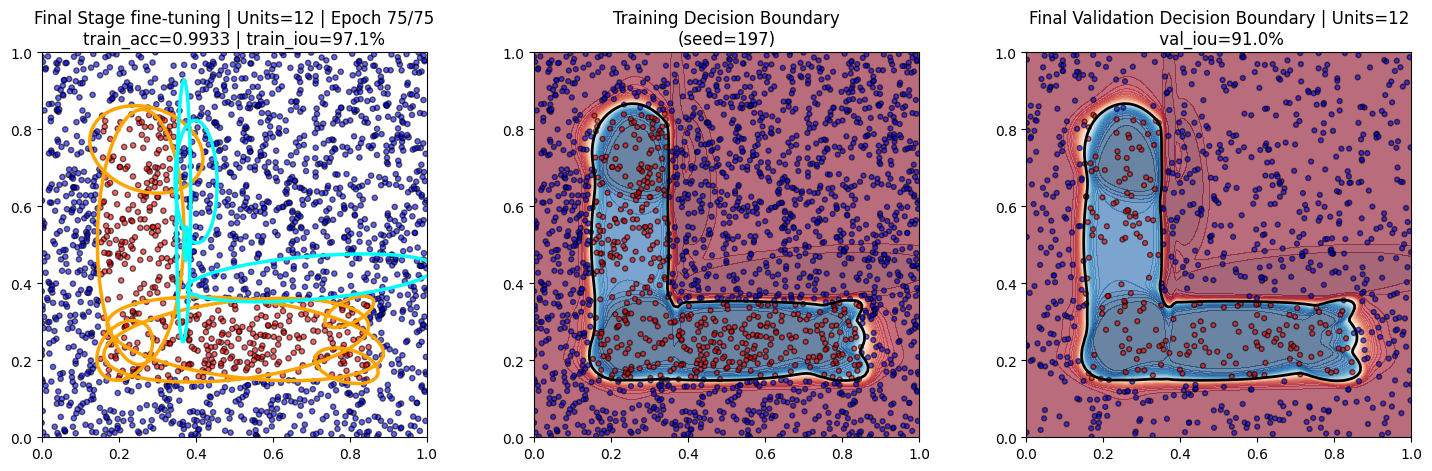

In [12]:
RndSeed.set_seed(197)  # Fixed seed for reproducibility

# Generate L-shaped polygon data
l_shape_corners = [(0.15, 0.15), (0.85, 0.15), (0.85, 0.35), (0.35, 0.35), (0.35, 0.85), (0.15, 0.85)]
X_lshape, y_lshape, _ = generate_polygon_data(n=3000, corners=l_shape_corners)

model_lshape, iou_lshape, X_train, y_train, X_val, y_val = build_and_train_model(
    X_lshape, y_lshape, 
    b_validation=True, 
    plot_frame_interval=5, 
    verbose=1
)

### 6.2 S-Shape Classification

🎲 Random seed set to: 197


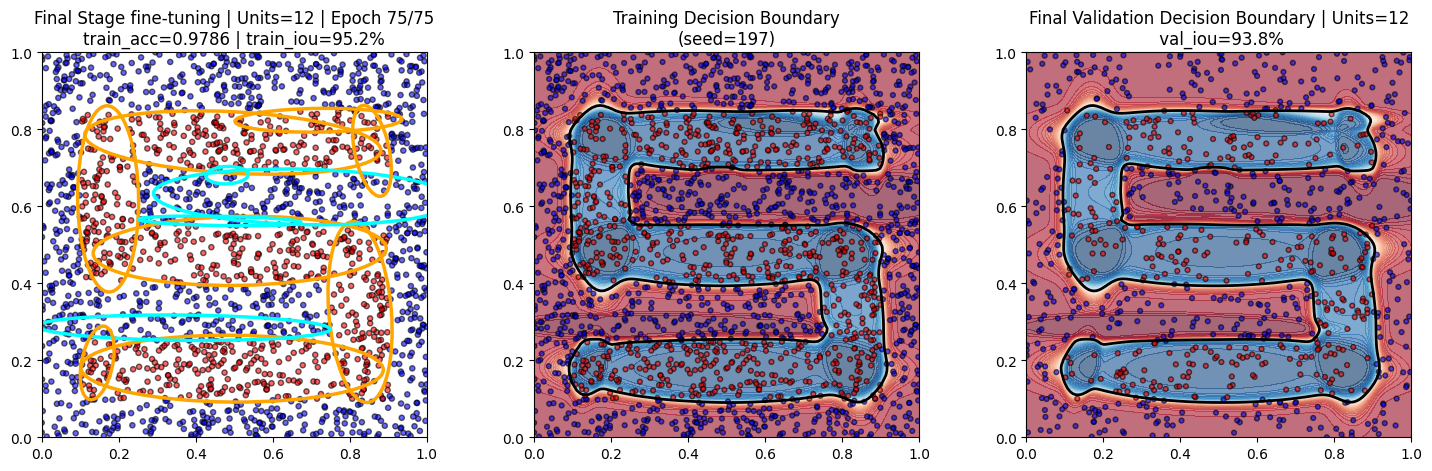

In [14]:
RndSeed.set_seed(197)  # Fixed seed for reproducibility

# Generate S-shaped polygon data 
s_shape_corners = [
    (0.1, 0.1), (0.9, 0.1), (0.9, 0.55), (0.25, 0.55), 
    (0.25, 0.7), (0.9, 0.7), (0.9, 0.85), (0.1, 0.85), 
    (0.1, 0.4), (0.75, 0.4), (0.75, 0.25), (0.1, 0.25)
]
X_sshape, y_sshape, _ = generate_polygon_data(n=3000, corners=s_shape_corners)

model_sshape, iou_sshape, _, _, _, _ = build_and_train_model(
    X_sshape, y_sshape, 
    b_validation=True, 
    plot_frame_interval=5, 
    verbose=1
)

### 6.3 Star Shape Classification

🎲 Random seed set to: 197


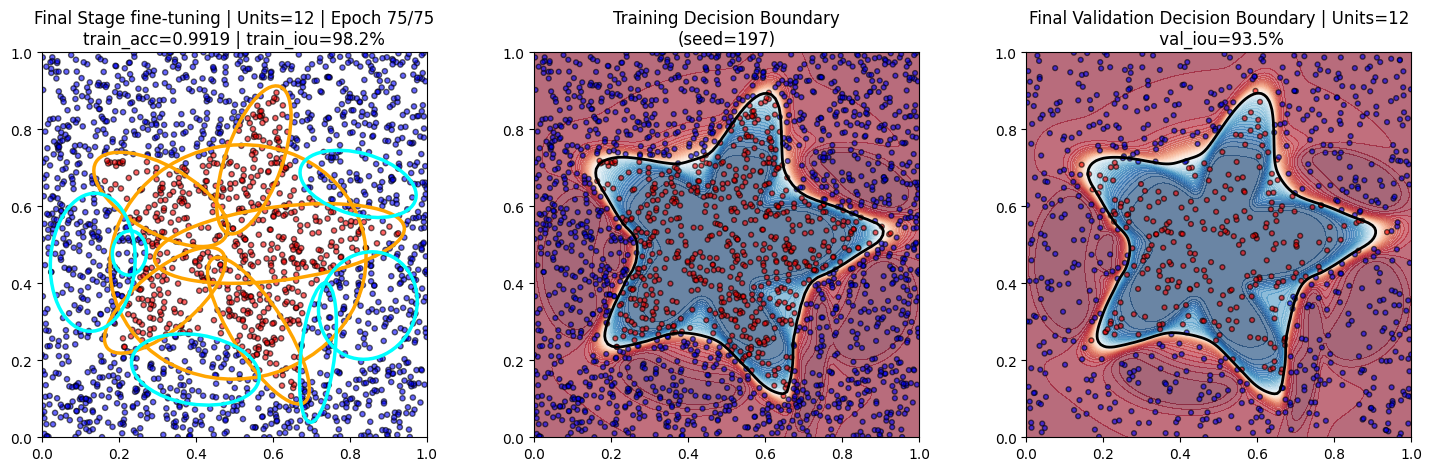

In [13]:
RndSeed.set_seed(197)  # Fixed seed for reproducibility

# Generate 5-pointed star data
X_star, y_star, _ = generate_n_star_data(n=3000, n_corners=5, inner_radius=0.22, outer_radius=0.45)

model_star, iou_star, _, _, _, _ = build_and_train_model(
    X_star, y_star,
    b_validation=True, 
    plot_frame_interval=5, 
    verbose=1
)

### 6.4 Donut Shape Classification

🎲 Random seed set to: 197


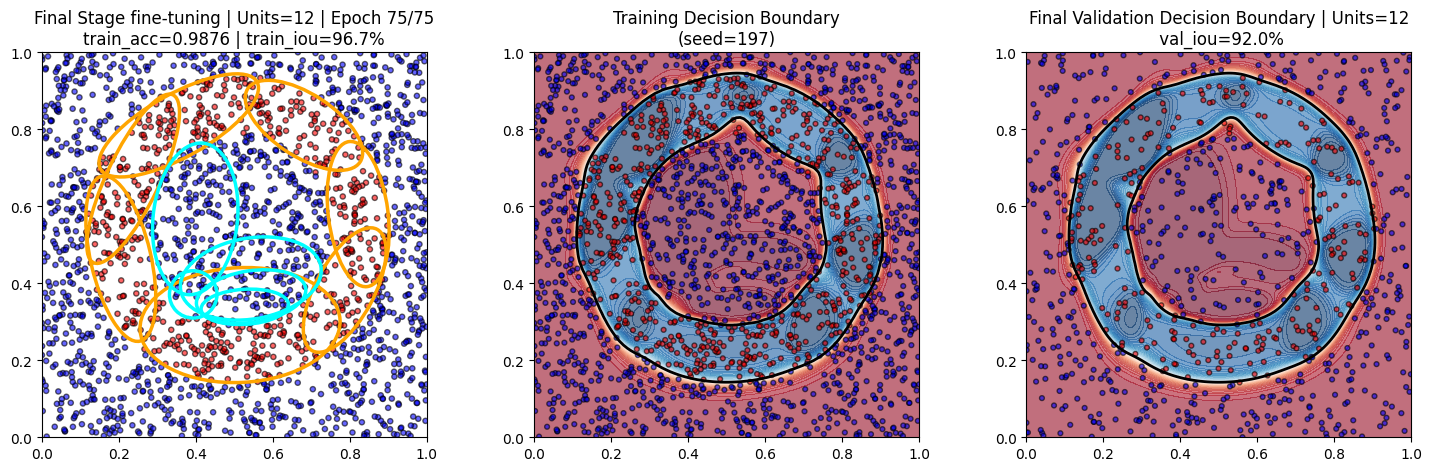

In [12]:
RndSeed.set_seed(197)  # Fixed seed for reproducibility

# Generate donut/annulus data
X_donut, y_donut, _ = generate_donut_data(n=3000)

model_donut, iou_donut, _, _, _, _ = build_and_train_model(
    X_donut, y_donut, 
    b_validation=True, 
    plot_frame_interval=5, 
    verbose=1
)

### 6.5 Figure-Eight Shape Classification

🎲 Random seed set to: 197


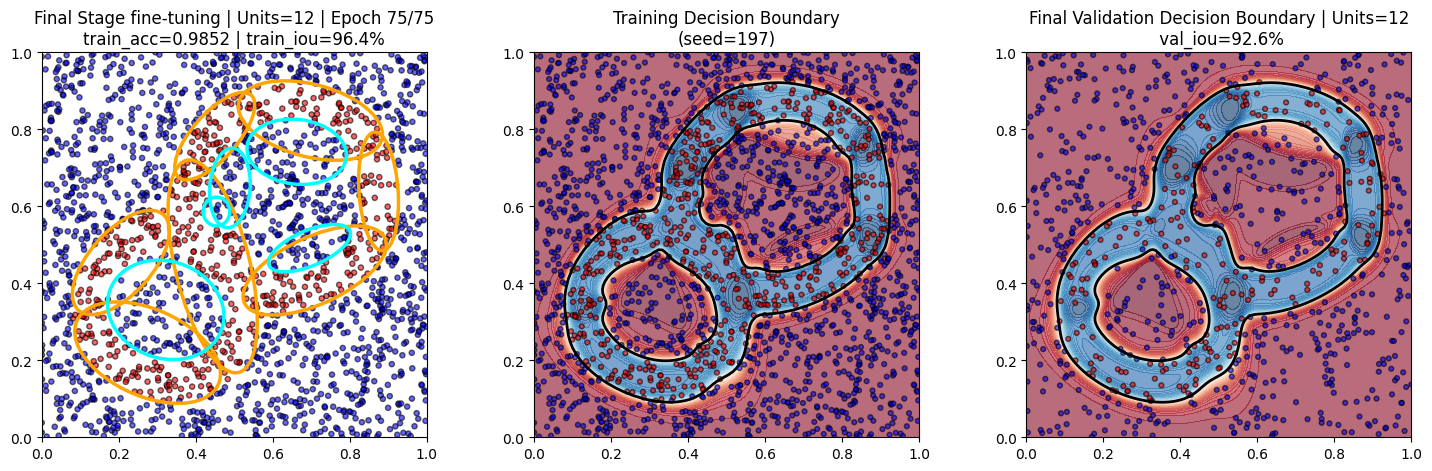

In [13]:
RndSeed.set_seed(197)  # Fixed seed for reproducibility

# Generate figure-eight (double donut) data
X_eight, y_eight, _ = generate_eight_shape_data(n=3000)

model_eight, iou_eight, _, _, _, _ = build_and_train_model(
    X_eight, y_eight, 
    b_validation=True, 
    plot_frame_interval=5, 
    verbose=1
)


---

## 7. Interactive Drawing Canvas

**Note:** The interactive canvas requires also `ipycanvas` package and may not work in all environments (particularly Kaggle at the time of publication: september 2025). It works well in local Jupyter environments and Google Colab.

This section provides an interactive drawing interface where you can:
- Draw custom shapes directly on a canvas
- Train the Soft Ellipse RBF model on your drawings
- Observe how the algorithm adapts to hand-drawn non-convex shapes

### Setup Interactive Canvas

In [ ]:
CANVAS_AVAILABLE = True # Set to True if ipycanvas is installed and working(registered)
# CANVAS_AVAILABLE = False # Set to True if ipycanvas is installed and working(registered)

# ATTENTION: This code may not work on Kaggle as ipycanvas is not registered
# You can execute this locally or in Google Colab

# Requirements: ipywidgets and ipycanvas packages
# Install via: !pip install ipywidgets ipycanvas

# For Google Colab, also uncomment these lines:
# from google.colab import output
# output.enable_custom_widget_manager()

if CANVAS_AVAILABLE:
    from ipycanvas import Canvas
    import ipywidgets as widgets

    canvas_size = 56  # Optimized for performance

    # Create drawing canvas
    canvas = Canvas(width=canvas_size, height=canvas_size, sync_image_data=True)
    canvas.layout.border = "2px solid #333"  # Add border for visibility

    # Scale up visual display while keeping drawing resolution
    visual_scale = 4
    canvas.layout.width = f"{canvas_size * visual_scale}px"
    canvas.layout.height = f"{canvas_size * visual_scale}px"

    # Initialize with blue background (outside class)
    canvas.fill_style = 'blue'
    canvas.fill_rect(0, 0, canvas_size, canvas_size)

    # Mouse interaction state
    is_drawing = False
    erase_mode = False
    last_x, last_y = None, None

    # Mouse event handlers for smooth drawing
    @canvas.on_mouse_down
    def on_mouse_down(x, y):
        global is_drawing, last_x, last_y
        is_drawing = True
        last_x, last_y = x, y
        
        if erase_mode:
            canvas.fill_style = 'blue'  # Erase with blue (outside)
        else:
            canvas.fill_style = 'red'   # Draw with red (inside)
        canvas.fill_circle(x, y, 4)

    @canvas.on_mouse_move
    def on_mouse_move(x, y):
        global is_drawing, last_x, last_y
        if is_drawing and last_x is not None and last_y is not None:
            if erase_mode:
                canvas.stroke_style = 'blue'
            else:
                canvas.stroke_style = 'red'
            canvas.line_width = 8
            canvas.fill_circle(x, y, 4)
            # Draw smooth line between points
            canvas.begin_path()
            canvas.move_to(last_x, last_y)
            canvas.line_to(x, y)
            canvas.stroke()
            
            last_x, last_y = x, y

    @canvas.on_mouse_up
    def on_mouse_up(x, y):
        global is_drawing, last_x, last_y
        is_drawing = False
        last_x, last_y = None, None

    # Control buttons
    btn_clear = widgets.Button(description="Clear Canvas")
    btn_draw = widgets.ToggleButton(description="🔴 Draw (Red)", button_style='success', value=True)
    btn_erase = widgets.ToggleButton(description="🔵 Erase (Blue)", button_style='', value=False)
    out = widgets.Output()

    # Mode switching functions
    def set_draw_mode(change):
        global erase_mode
        if change['new']:
            erase_mode = False
            btn_draw.value = True
            btn_erase.value = False
            btn_draw.button_style = 'success'
            btn_erase.button_style = ''

    def set_erase_mode(change):
        global erase_mode
        if change['new']:
            erase_mode = True
            btn_draw.value = False
            btn_erase.value = True
            btn_draw.button_style = ''
            btn_erase.button_style = 'info'

    btn_draw.observe(set_draw_mode, names='value')
    btn_erase.observe(set_erase_mode, names='value')

    def clear_canvas(b):
        """Reset canvas to blue background."""
        canvas.clear()
        canvas.fill_style = 'blue'
        canvas.fill_rect(0, 0, canvas_size, canvas_size)

    btn_clear.on_click(clear_canvas)

    # Layout the interface
    canvas_widget = widgets.VBox([canvas], layout=widgets.Layout(width='auto', align_items='center'))
    mode_buttons = widgets.HBox([btn_draw, btn_erase], layout=widgets.Layout(justify_content='center'))
    action_buttons = widgets.HBox([btn_clear], layout=widgets.Layout(justify_content='center'))
    output_widget = widgets.VBox([out], layout=widgets.Layout(width='auto'))

    # Create and display the main interface
    main_interface = widgets.VBox([canvas_widget, mode_buttons, action_buttons, output_widget], 
                                layout=widgets.Layout(align_items='center'))
    display(main_interface)
else:
    print("Canvas not available. Please install ipycanvas: pip install ipycanvas")

### Canvas Data Processing & Training

Functions to convert canvas drawings into training data and visualize the sampling process.

In [ ]:
if CANVAS_AVAILABLE:
    def sample_canvas_points(n):
        """Convert canvas drawing to training data points.
        
        Processes the canvas image to extract binary classification data:
        - Red pixels → inside class (label=1)
        - Blue pixels → outside class (label=0)
        
        Args:
            n: Number of data points to sample
            
        Returns:
            X_data: Normalized coordinates (n, 2)
            y_data: Binary labels (n,)
        """
        img = canvas.get_image_data(0, 0, canvas_size, canvas_size)
        
        # Convert RGB to binary classification
        red_channel = img[:, :, 0]
        blue_channel = img[:, :, 2]
        
        # Red pixels = inside (1), Blue pixels = outside (0)
        binary = ((red_channel > 127) & (blue_channel < 127)).astype(np.uint8)

        # Generate coordinate grid
        coords = np.array(np.meshgrid(np.arange(canvas_size), np.arange(canvas_size))).reshape(2, -1).T
        pixel_values = binary.flatten()
        
        # Handle sampling with/without replacement
        total_pixels = canvas_size * canvas_size
        use_replacement = n > total_pixels
        
        if use_replacement:
            print(f"Note: Requested {n} samples from {total_pixels} pixels - using replacement sampling")
        
        # Random sampling
        idx = np.random.choice(len(coords), n, replace=use_replacement)
        
        # Extract and normalize coordinates
        x_flat = coords[idx, 0]
        y_flat = coords[idx, 1]
        
        # Normalize to [0, 1] range
        x_normalized = x_flat / (canvas_size - 1)
        y_normalized = (canvas_size - 1 - y_flat) / (canvas_size - 1)  # Flip Y axis
        
        # Combine coordinates and add adaptive noise
        x_data = np.column_stack([x_normalized, y_normalized])
        
        # Adaptive noise: decreases with sample density
        base_noise = 0.025  
        noise_factor = min(1.0, 1000 / n)
        noise_amount = base_noise * noise_factor
        
        x_data = x_data + np.random.uniform(-noise_amount, noise_amount, x_data.shape)
        x_data = x_data.clip(1e-6, 1 - 1e-6)  # Avoid exact boundary values
        
        y_data = pixel_values[idx]
        return x_data, y_data

    def visualize_canvas_sampling(n=1000):
        """Visualize the canvas sampling process and data distribution.
        
        Shows side-by-side comparison of:
        1. Original canvas drawing (processed binary image)
        2. Sampled data points with class distribution
        """
        X_sample, y_sample = sample_canvas_points(n)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        # Process canvas image
        img = canvas.get_image_data(0, 0, canvas_size, canvas_size)
        red_channel = img[:, :, 0]
        blue_channel = img[:, :, 2]
        
        # Create binary classification visualization
        binary = ((red_channel > 127) & (blue_channel < 127)).astype(np.uint8)
        
        # RGB visualization of processed canvas
        canvas_rgb = np.zeros((canvas_size, canvas_size, 3), dtype=np.uint8)
        canvas_rgb[:, :, 0] = binary * 255      # Red channel for inside
        canvas_rgb[:, :, 2] = (1 - binary) * 255  # Blue channel for outside
        
        ax1.imshow(canvas_rgb, origin='upper')
        ax1.set_title(f"Processed Canvas (Binary {canvas_size}x{canvas_size})\n(Red=Inside, Blue=Outside)")
        ax1.set_xlabel("X (canvas)")
        ax1.set_ylabel("Y (canvas, top=0)")
        
        # Show sampled points
        colors = ['blue' if val == 0 else 'red' for val in y_sample]
        n_inside = np.sum(y_sample)
        n_outside = n - n_inside
        
        ax2.scatter(X_sample[:, 0], X_sample[:, 1], c=colors, edgecolor="none", s=8, alpha=0.8)
        ax2.set_title(f"Sampled Points (n={n})\n(Red={n_inside}, Blue={n_outside})")
        ax2.set_xlabel("X (plot)")
        ax2.set_ylabel("Y (plot, bottom=0)")
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.set_aspect('equal')
        
        plt.tight_layout()
        plt.show()

        print(f"Sampled {n} points: {n_inside} inside (red), {n_outside} outside (blue)")

In [ ]:
if CANVAS_AVAILABLE:
    # Visualize the sampling process
    visualize_canvas_sampling(n=3000)

### Train Model on Canvas Drawing

Sample data from your canvas drawing and train the Soft Ellipse RBF model on your custom shape!

In [ ]:
if CANVAS_AVAILABLE:
    # Visualize the sampling process
    # visualize_canvas_sampling(n=3000)

    # Train model on canvas data
    RndSeed.set_seed(197)  # Fixed seed for reproducibility

    # Generate samples from your canvas drawing
    X_canvas, y_canvas = sample_canvas_points(n=3000)

    model_canvas, iou_canvas, _, _, _, _ = build_and_train_model(
        X_canvas, y_canvas, 
        b_validation=True, 
        plot_frame_interval=5, 
        verbose=1
    )

---
## Conclusion

This notebook showed how **Soft Elliptical RBFs** can be used for non-convex shape classification.  
Key takeaways:  

- **Targeted unit placement** with DBSCAN helps the model focus on errors  
- **Incremental learning** builds up complexity step by step  
- **Compact and efficient** thanks to pruning and medoid selection  
- **Versatile** enough to handle donuts, stars, and even hand-drawn shapes  

Overall, it’s a practical way to combine neural networks with clear geometric meaning.




## 🔗 See also

👈 *Previous*: [Convex Polygon Shape Classification with Custom Activations](<https://github.com/Dani-Luk/kaggle-wrapping-convex-shape-classifier/tree/main>)